<a href="https://colab.research.google.com/github/aleks-haksly/Postypashka/blob/main/DA/01%20HW/HW_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Всё необходимое для выполнения данной лабораторной работы!
import requests
from time import sleep

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', 100)

## Задание 1. Парсинг - 10 баллов

В этом задании Вам предстоит работать с API сайта <a target="_blank" href="hh.ru">hh.ru</a>. Документация доступна по <a target="_blank" href="https://github.com/hhru/api/blob/master/docs/vacancies.md#search">ссылке</a>.

**Задача:**
1. выбрать 5 интересующих вас профессий (не смежных, т.е. Аналатик и Data Engineer не считается корректным)
2. затем получить доступные по данным профессиям вакансии в Москве и выделить их физические координаты
3. нанести полученные координаты на карту местоположения компаний

*Пример запроса для профессии:*

In [3]:
URL = 'https://api.hh.ru/vacancies'

params = {
    'text': "Физик-ядерщик",
    'area': 1,
    'page': 0,
    'per_page': 10
}

data = requests.get(URL, params).json()
data

{'items': [],
 'found': 0,
 'pages': 1,
 'page': 0,
 'per_page': 10,
 'clusters': None,
 'arguments': None,
 'fixes': None,
 'suggests': None,
 'alternate_url': 'https://hh.ru/search/vacancy?area=1&enable_snippets=true&items_on_page=10&text=%D0%A4%D0%B8%D0%B7%D0%B8%D0%BA-%D1%8F%D0%B4%D0%B5%D1%80%D1%89%D0%B8%D0%BA'}

Если Ваш запрос прошел успешно, то вы получите следующие ключи (значения данных ключей вы найдете по ссылке на документацию):

In [4]:
data.keys()

dict_keys(['items', 'found', 'pages', 'page', 'per_page', 'clusters', 'arguments', 'fixes', 'suggests', 'alternate_url'])

Выберете для нас 5 наиболее интересных специальностей и получите по ним имеющиеся вакансии:

In [5]:
URL_areas = 'https://api.hh.ru/areas'
URL_professions = 'https://api.hh.ru/professional_roles'
URL_vacancies = 'https://api.hh.ru/vacancies'

In [6]:
data_areas = requests.get(URL_areas).json()
sleep(0.5)
data_professions = requests.get(URL_professions).json()

In [7]:
def get_city_id_by_name(data:dict=data_areas, county_name:str='Россия', city_name:str='Москва') -> str | None:
    """
    Returns the city ID given a country name and city name.

    :param data: A dictionary containing country and city data.
    :param county_name: The name of the country.
    :param city_name: The name of the city.
    :return: The ID of the city if found, otherwise None
    """
    for country in data_areas:
        if country.get('name', []) == county_name:
            for city in country['areas']:
                if city.get('name', []) == city_name:
                    return city.get('id', None)

In [8]:
def get_random_professions_names(data:dict=data_professions, n:int=5) -> list:
    """
    Returns a list of random profession names.

    :param data: A dictionary containing professions data.
    :param n: The number of profession names to return.
    :return: A list of random profession names
    """
    result = []
    profession_categories = [profession_categories.get('name') for profession_categories in data.get('categories')][:-1] #Категорию "другое" не рассматриваем
    # Выберем по 1 случайной профессии из n случайных категорий
    for profession_category in np.random.choice(profession_categories, size=n, replace=False):
        for profession in data_professions.get('categories'):
            if profession.get('name', []) == profession_category:
                result.append(np.random.choice(profession.get('roles'), size=1, replace=False)[0].get('name'))
                break
    return result


In [9]:
def get_vacancies_page(vacancy_name:str, page:int=0, city_id:str='1') -> dict:
    """
    Fetches a page of vacancies based on the vacancy name and city.

    :param vacancy_name: The name of the vacancy to search for.
    :param page: The page number to fetch (defaults to 0).
    :param city: The city to filter vacancies by (defaults to 'Москва').
    :return: A JSON object containing the vacancies or None if an error occurs.
    """
    params = {
        'text': vacancy_name,
        'area': city_id,
        'page': page,
        'per_page': 100,
        'search_field': "name" # чтобы отсеить поиск в описании вакансии, иначе в выдаче много мусора
    }
    try:
        response = requests.get(URL_vacancies, params)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching vacancies: {e}")
        return None
    return response.json()

In [10]:
def get_vacancies(vacancy_name, city='Москва'):
    """
    Retrieves all vacancies matching the specified vacancy name and city by paginating through the API results.

    :param vacancy_name: The name of the vacancy to search for.
    :param city: The city to filter the vacancies by (defaults to 'Москва').
    :return: A dictionary containing a list of vacancies and the total number found.
    """
    city_id = get_city_id_by_name(city_name=city)
    page = 0
    vacancies = []
    current_page = get_vacancies_page(vacancy_name=vacancy_name, page=page, city_id=city_id)
    if not current_page:
        return{'items': [], 'found': 0, 'fetched': 0}

    vacancies.extend(current_page.get('items', []))
    total_pages = current_page.get('pages', 0)
    total_vacancies = current_page.get('found', 0)

    for page in range(1, total_pages):

        sleep(np.random.rand() + 0.5)

        current_page = get_vacancies_page(vacancy_name=vacancy_name, page=page, city_id=city_id)
        if not current_page:
            break
        vacancies.extend(current_page.get('items', []))

    return {'items': vacancies, 'found': total_vacancies, 'fetched': len(vacancies)}

In [11]:
np.random.seed(42)
vacancies_info = dict()
data = []
for vacancy_name in get_random_professions_names(n=5):
    vacancies = get_vacancies(vacancy_name=vacancy_name)
    data.extend(vacancies.get('items'))
    vacancies_info[vacancy_name] = {
        'found': vacancies.get('found'),
        'fetched': vacancies.get('fetched')
    }
    print(f'{vacancies.get("fetched")} of {vacancies.get("found")} vacancies for {vacancy_name} fetched')

1 of 1 vacancies for Артист, актер, аниматор fetched
43 of 43 vacancies for Агроном fetched
92 of 92 vacancies for Автомойщик fetched
252 of 252 vacancies for Финансовый директор (CFO) fetched
184 of 184 vacancies for Психолог fetched


Посчитайте сколько всего найдено вакансий:

In [12]:
vacancies_info

{'Артист, актер, аниматор': {'found': 1, 'fetched': 1},
 'Агроном': {'found': 43, 'fetched': 43},
 'Автомойщик': {'found': 92, 'fetched': 92},
 'Финансовый директор (CFO)': {'found': 252, 'fetched': 252},
 'Психолог': {'found': 184, 'fetched': 184}}

In [13]:
print(f" Всего вакансий найдено: {sum(v['found'] for v in vacancies_info.values())}")

 Всего вакансий найдено: 572


Создайте структуру данных, которая будет хранить в себе имя компании и ее координаты (широта и долгота):

In [14]:
from collections import namedtuple

Company = namedtuple('Company', ['name', 'lat', 'lng'])

Создайте экземпляр этой структуры данных для каждой компании, которая выставила вакансию:

In [15]:
companies = set(Company(company.get('employer').get('name'), \
                       (company.get('address') or dict()).get('lat'), \
                       (company.get('address') or dict()).get('lng')) \
                for company in data
                )

Найдите количество вакансий, у которых заданы координаты (значения данных может быть пустым):

In [16]:
n_vacances = sum(bool((vacancy.get('address') or dict()).get('lat') and \
                      (vacancy.get('address') or dict()).get('lng')
                     )
                for vacancy in data
                )

In [17]:
print(f'Всего вакансий с координатами: {n_vacances}')

Всего вакансий с координатами: 337


Отберите вакансии, которые расположены в пределах МКАД (можно грубо):

In [18]:
# with gratitude to: https://misha.agency/javascript/rasschet-rasstoyaniya-ot-mkad.html#mkad-coordinates
mkadPoints =  [
	[ 55.774558, 37.842762 ],
	[ 55.76522, 37.842789 ],
	[ 55.755723, 37.842627 ],
	[ 55.747399, 37.841828 ],
	[ 55.739103, 37.841217 ],
	[ 55.730482, 37.840175 ],
	[ 55.721939, 37.83916 ],
	[ 55.712203, 37.837121 ],
	[ 55.703048, 37.83262 ],
	[ 55.694287, 37.829512 ],
	[ 55.68529, 37.831353 ],
	[ 55.675945, 37.834605 ],
	[ 55.667752, 37.837597 ],
	[ 55.658667, 37.839348 ],
	[ 55.650053, 37.833842 ],
	[ 55.643713, 37.824787 ],
	[ 55.637347, 37.814564 ],
	[ 55.62913, 37.802473 ],
	[ 55.623758, 37.794235 ],
	[ 55.617713, 37.781928 ],
	[ 55.611755, 37.771139 ],
	[ 55.604956, 37.758725 ],
	[ 55.599677, 37.747945 ],
	[ 55.594143, 37.734785 ],
	[ 55.589234, 37.723062 ],
	[ 55.583983, 37.709425 ],
	[ 55.578834, 37.696256 ],
	[ 55.574019, 37.683167 ],
	[ 55.571999, 37.668911 ],
	[ 55.573093, 37.647765 ],
	[ 55.573928, 37.633419 ],
	[ 55.574732, 37.616719 ],
	[ 55.575816, 37.60107 ],
	[ 55.5778, 37.586536 ],
	[ 55.581271, 37.571938 ],
	[ 55.585143, 37.555732 ],
	[ 55.587509, 37.545132 ],
	[ 55.5922, 37.526366 ],
	[ 55.594728, 37.516108 ],
	[ 55.60249, 37.502274 ],
	[ 55.609685, 37.49391 ],
	[ 55.617424, 37.484846 ],
	[ 55.625801, 37.474668 ],
	[ 55.630207, 37.469925 ],
	[ 55.641041, 37.456864 ],
	[ 55.648794, 37.448195 ],
	[ 55.654675, 37.441125 ],
	[ 55.660424, 37.434424 ],
	[ 55.670701, 37.42598 ],
	[ 55.67994, 37.418712 ],
	[ 55.686873, 37.414868 ],
	[ 55.695697, 37.407528 ],
	[ 55.702805, 37.397952 ],
	[ 55.709657, 37.388969 ],
	[ 55.718273, 37.383283 ],
	[ 55.728581, 37.378369 ],
	[ 55.735201, 37.374991 ],
	[ 55.744789, 37.370248 ],
	[ 55.75435, 37.369188 ],
	[ 55.762936, 37.369053 ],
	[ 55.771444, 37.369619 ],
	[ 55.779722, 37.369853 ],
	[ 55.789542, 37.372943 ],
	[ 55.79723, 37.379824 ],
	[ 55.805796, 37.386876 ],
	[ 55.814629, 37.390397 ],
	[ 55.823606, 37.393236 ],
	[ 55.83251, 37.395275 ],
	[ 55.840376, 37.394709 ],
	[ 55.850141, 37.393056 ],
	[ 55.858801, 37.397314 ],
	[ 55.867051, 37.405588 ],
	[ 55.872703, 37.416601 ],
	[ 55.877041, 37.429429 ],
	[ 55.881091, 37.443596 ],
	[ 55.882828, 37.459065 ],
	[ 55.884625, 37.473096 ],
	[ 55.888897, 37.48861 ],
	[ 55.894232, 37.5016 ],
	[ 55.899578, 37.513206 ],
	[ 55.90526, 37.527597 ],
	[ 55.907687, 37.543443 ],
	[ 55.909388, 37.559577 ],
	[ 55.910907, 37.575531 ],
	[ 55.909257, 37.590344 ],
	[ 55.905472, 37.604637 ],
	[ 55.901637, 37.619603 ],
	[ 55.898533, 37.635961 ],
	[ 55.896973, 37.647648 ],
	[ 55.895449, 37.667878 ],
	[ 55.894868, 37.681721 ],
	[ 55.893884, 37.698807 ],
	[ 55.889094, 37.712363 ],
	[ 55.883555, 37.723636 ],
	[ 55.877501, 37.735791 ],
	[ 55.874698, 37.741261 ],
	[ 55.862464, 37.764519 ],
	[ 55.861979, 37.765992 ],
	[ 55.850257, 37.788216 ],
	[ 55.850383, 37.788522 ],
	[ 55.844167, 37.800586 ],
	[ 55.832707, 37.822819 ],
	[ 55.828789, 37.829754 ],
	[ 55.821072, 37.837148 ],
	[ 55.811599, 37.838926 ],
	[ 55.802781, 37.840004 ],
	[ 55.793991, 37.840965 ],
	[ 55.785017, 37.841576 ],
	[ 55.780825, 37.842095 ]
]

In [19]:
def in_poly(point, poly = mkadPoints):
    """
    Определяет, находится ли геоточка внутри полигона геоточек или за его пределами.

    :param point: Заданная геоточка в формате [широта, долгота]
    :param poly: Массив геоточек полигона (например, МКАДа)
    :return: True/False (находится внутри/находится за пределами)
    """
    x, y = point
    inside = False
    if not all([x, y]):
        return inside
    j = len(poly) - 1
    for i in range(len(poly)):
        xi, yi = poly[i]
        xj, yj = poly[j]

        intersect = ((yi > y) != (yj > y)) and (x < (xj - xi) * (y - yi) / (yj - yi) + xi)
        if intersect:
            inside = not inside

        j = i

    return inside

In [20]:
vacancies_inside_mkad = list(filter(lambda vacancy: in_poly([(vacancy.get('address') or dict()).get('lat'), (vacancy.get('address') or dict()).get('lng')]), data))
len(vacancies_inside_mkad)

239

Постройте график в координатах "широта-долгота" для отображения вакансий внутри МКАД (не забывайте прописать прозрачность, чтобы увидеть скопления):

In [21]:
lat = [vacany.get('address').get('lat') for  vacany in vacancies_inside_mkad]
lng = [vacany.get('address').get('lng') for  vacany in vacancies_inside_mkad]

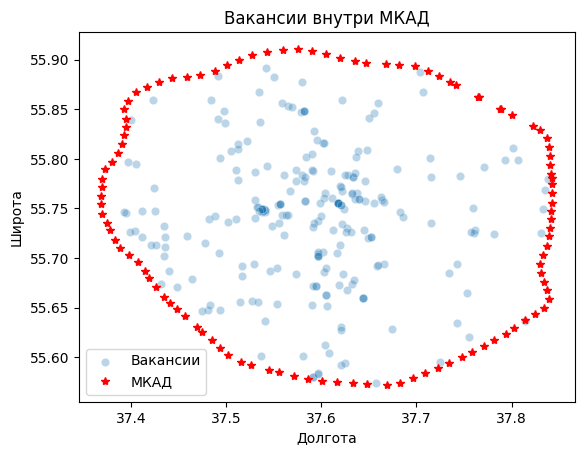

In [22]:
sns.scatterplot(data=pd.DataFrame(vacancies_inside_mkad), x=lng, y=lat, alpha=0.3).set_title('Вакансии внутри МКАД')
for y, x in mkadPoints:
  plt.plot(x, y, 'r*')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.legend(['Вакансии', 'МКАД']);

**Сделайте выводы о проделанной работе:**

Вакансии найдены и отфильтрованы по признаку нахождения внутри МКАД, в дальнейшем интересно было бы добавить возможность фильтрации по зарпатаной вилке, требуемому опыту работы и свежести вакансии. Также для изучения данных, удобнее их преобразовать в pandas.DataFrame

In [45]:
from collections.abc import MutableMapping

def flatten_dict(d: MutableMapping, parent_key: str = '', sep: str ='_') -> MutableMapping:
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, MutableMapping):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)


In [57]:
df = pd.DataFrame.from_records([flatten_dict(v) for v in vacancies_inside_mkad])
df.head()

,id,premium,name,department,has_test,response_letter_required,area_id,area_name,area_url,salary_from,salary_to,salary_currency,salary_gross,type_id,type_name,address_city,address_street,address_building,address_lat,address_lng,address_description,address_raw,address_metro,address_metro_stations,address_id,response_url,sort_point_distance,published_at,created_at,archived,apply_alternate_url,show_logo_in_search,insider_interview,url,alternate_url,relations,employer_id,employer_name,employer_url,employer_alternate_url,employer_logo_urls_90,employer_logo_urls_original,employer_logo_urls_240,employer_vacancies_url,employer_accredited_it_employer,employer_trusted,snippet_requirement,snippet_responsibility,contacts,schedule_id,schedule_name,working_days,working_time_intervals,working_time_modes,accept_temporary,professional_roles,accept_incomplete_resumes,experience_id,experience_name,employment_id,employment_name,adv_response_url,is_adv_vacancy,adv_context,address_metro_station_name,address_metro_line_name,address_metro_station_id,address_metro_line_id,address_metro_lat,address_metro_lng,employer_logo_urls,salary,branding_type,branding_tariff,department_id,department_name,insider_interview_id,insider_interview_url
0,107240238,False,Дед Мороз / Аниматор / Артист / Актер,NaN,False,False,1,Москва,https://api.hh.ru/areas/1,160000.0,NaN,RUR,False,open,Открытая,Москва,улица Расковой,11А,55.788905,37.573133,None,"Москва, улица Расковой, 11А",NaN,[],7673240,None,None,2024-09-13T11:17:23+0300,2024-09-13T11:17:23+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,NaN,https://api.hh.ru/vacancies/107240238?host=hh.ru,https://hh.ru/vacancy/107240238,[],1376090,Море Шоу,https://api.hh.ru/employers/1376090,https://hh.ru/employer/1376090,https://img.hhcdn.ru/employer-logo/6873634.png,https://img.hhcdn.ru/employer-logo-original/13...,https://img.hhcdn.ru/employer-logo/6873635.png,https://api.hh.ru/vacancies?employer_id=1376090,False,True,"Креативность, умение и желание работать с деть...",Дед Мороз | <highlighttext>Аниматор</highlight...,None,fullDay,Полный день,"[{'id': 'only_saturday_and_sunday', 'name': 'П...","[{'id': 'from_four_to_six_hours_in_a_day', 'na...","[{'id': 'start_after_sixteen', 'name': 'С нача...",True,"[{'id': '13', 'name': 'Артист, актер, аниматор'}]",True,between1And3,От 1 года до 3 лет,full,Полная занятость,None,False,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,107065128,False,Специалист по уходу за офисными растениями (са...,NaN,False,False,1,Москва,https://api.hh.ru/areas/1,25000.0,100000.0,RUR,False,open,Открытая,Москва,Пресненская набережная,12,55.749633,37.537434,None,"Москва, Пресненская набережная, 12",NaN,"[{'station_name': 'Деловой центр', 'line_name'...",11920647,None,None,2024-09-10T15:15:41+0300,2024-09-10T15:15:41+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,NaN,https://api.hh.ru/vacancies/107065128?host=hh.ru,https://hh.ru/vacancy/107065128,[],3926338,Дизайн Инжиниринг,https://api.hh.ru/employers/3926338,https://hh.ru/employer/3926338,NaN,NaN,NaN,https://api.hh.ru/vacancies?employer_id=3926338,False,True,"Диплом об профильном образовании (высшее, мини...",Комплексный уход за офисными растениями. Знани...,None,flexible,Гибкий график,[],"[{'id': 'from_four_to_six_hours_in_a_day', 'na...",[],True,"[{'id': '7', 'name': 'Агроном'}]",False,between1And3,От 1 года до 3 лет,part,Частичная занятость,None,False,None,Деловой центр,Солнцевская,133.468,133,55.74910,37.53950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,106041540,False,Производственный директор - Главный агроном (Р...,NaN,False,False,1,Москва,https://api.hh.ru/areas/1,200000.0,300000.0,RUR,True,open,Открытая,Москва,None,None,55.685026,37.733904,None,Москва,NaN,[],16102152,None,None,2024-08-20T10:23:03+0300,2024-08-20T10:23:03+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,NaN,https://api.hh.ru/vacancies/106041540?host=hh.ru,https://hh.ru/vacancy/106041540,[],1689259,ДЖЕЙКЕТ РАБОТА,https://api.hh.ru/empl

Вам предстоит проанализировать датасет, содержащий информацию об бриллианта, их стоимости и остальных характеристиках.



Поясним значения хранящиеся в колонках:
*   `cut` - огранка бриллианта (относится к одной из примерно 10 наиболее распространенных)
*   `color` - цвет бриллианта, прозрачные бриллианты имеют градацию `D-Z`, "более высокие" буквы - более желтоватые, но часто имеют лучшие значения, поскольку цвет трудно определить один раз в кольце
*   `clarity` - чистота бриллианта, наличие включений (внутренних дефектов), чем меньше и мельче, тем лучше
*   `carat_weight` - масса бриллианта (слабо связана с размером бриллианта, т.к. огранка и качество огранки, как правило, играют большую роль)
*   `cut_quality` - качество ограники по системе оценки GIA Cut
*   `lab` - лаборатория оценивания
*   `meas_length` - длина бриллианта
*   `meas_width` - ширина бриллианта
*   `meas_depth` - глубина бриллианта
*   `total_sales_price` - цена бриллианта в долларах.
*    **и прочие колонки**

Скачаем данные:

In [23]:
!gdown 10OJ30qlkE-7zK4JuVTDMY3U4nRB4tu_8
# если работайте в jupyter то скачайте датасет с https://drive.google.com/uc?id=10OJ30qlkE-7zK4JuVTDMY3U4nRB4tu_8

Downloading...
From: https://drive.google.com/uc?id=10OJ30qlkE-7zK4JuVTDMY3U4nRB4tu_8
To: /content/diamonds.csv
100% 35.4M/35.4M [00:00<00:00, 94.1MB/s]


Создадим DataFrame:

In [24]:
import pandas as pd

diamonds = pd.read_csv("diamonds.csv", index_col=0)

Выведете первые 5 строк датасета:

In [25]:
diamonds.head(5)

,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,culet_condition,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,N,unknown,62.7,59.0,2.85,2.87,1.79,M,M,unknown,NaN,unknown,unknown,unknown,unknown,200
1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,N,unknown,61.9,59.0,2.84,2.89,1.78,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,unknown,unknown,61.1,59.0,2.88,2.90,1.77,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,200
3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,unknown,unknown,62.0,59.0,2.86,2.88,1.78,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,N,unknown,64.9,58.5,2.79,2.83,1.82,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200


Найдите количество бриллиантов всего в данном датасете:

In [26]:
diamonds.shape[0]

219703

Выведите максимальную и минимальную цену бриллианта в формате `номер - цена`:

In [27]:
print('Максимальная цена: \n номер', ' - ', 'цена')
for idx in diamonds.loc[diamonds['total_sales_price'] == diamonds['total_sales_price'].max()].index:
  print(f'{idx:6d}', ' - ', diamonds['total_sales_price'].max())
  print()
print('Минимальная цена: \n номер', ' - ', 'цена')
for idx in diamonds.loc[diamonds['total_sales_price'] == diamonds['total_sales_price'].min()].index:
  print(f'{idx:6d}', ' - ', diamonds['total_sales_price'].min())

Максимальная цена: 
 номер  -  цена
219703  -  1449881

Минимальная цена: 
 номер  -  цена
     0  -  200
     1  -  200
     2  -  200
     3  -  200
     4  -  200
     5  -  200
     6  -  200
     7  -  200
     8  -  200
     9  -  200
    10  -  200
    11  -  200
    12  -  200
    13  -  200
    14  -  200
    15  -  200
    16  -  200
    17  -  200
    18  -  200
    19  -  200
    20  -  200
    21  -  200
    22  -  200


Посчитайте количество пропусков (пропуском считается значение `unknown` или `None`):

In [28]:
diamonds.replace('unknown', np.nan, inplace=True)
diamonds.isna().sum().rename('Количество пропусков')

,Количество пропусков
cut,0
color,9162
clarity,0
carat_weight,0
cut_quality,60607
lab,0
symmetry,0
polish,0
eye_clean,156916
culet_size,85740


In [29]:
print(f'Общее число полпусков: {diamonds.isna().sum().sum()}')

Общее число полпусков: 1891168


Найдите в каких столбцах присутствуют пропуски:

In [30]:
diamonds.isna().sum().loc[diamonds.isna().sum() > 0].rename('Количество пропусков')

,Количество пропусков
color,9162
cut_quality,60607
eye_clean,156916
culet_size,85740
culet_condition,204384
girdle_min,83432
girdle_max,84295
fluor_color,203977
fluor_intensity,143619
fancy_color_dominant_color,210539


В нашем датасете присутствуют колонки, которые начинаются с `fancy_color_` или `fluor_`. Большинство значений в этих колонках - `unknown` или `None`, поэтому мы считаем их малоинформативными.

Ваша задача:

найти количество таких колонок, которые начинаются с `fancy_color_` или `fluor_`:

In [31]:
cols_to_drop = diamonds.columns[diamonds.columns.str.startswith('fancy_color_') | diamonds.columns.str.startswith('fluor_')]
len(cols_to_drop)

6

найти количество информативных (не `None` или `unknown`) значений в этих колонках:

In [32]:
diamonds[cols_to_drop].isna().sum().apply(lambda x: diamonds.shape[0] - x).rename('Количество информативных значений')

,Количество информативных значений
fluor_color,15726
fluor_intensity,76084
fancy_color_dominant_color,9164
fancy_color_secondary_color,1062
fancy_color_overtone,388
fancy_color_intensity,9162


удалить данные колонки из датасета, сохранив изменения (в дальнейшем работаем измененным датасетом):

In [33]:
diamonds.drop(columns=cols_to_drop, inplace=True)

Проделайте тоже самое для колонок, начинающихся с `culet_`:

In [34]:

diamonds.drop(columns=diamonds.columns[diamonds.columns.str.startswith('culet_')], inplace=True)

Посчитайте сколько бы стоил (в тысячах долларов) сейф, в котором хранились бы все бриллианты из датасета:

In [35]:
# стоимостью сейфа принебрегаем
print(f'{diamonds.total_sales_price.sum() / 1e3: .0f}')

 1517722


Немного необоснованных манипуляций.

Выберите из датасета строки с четными индексами и выведете значения (не меняя нумерацию индексов):

In [36]:
diamonds.iloc[::2]

,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,NaN,62.7,59.0,2.85,2.87,1.79,M,M,200
2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,NaN,61.1,59.0,2.88,2.90,1.77,TN,M,200
4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,NaN,64.9,58.5,2.79,2.83,1.82,STK,STK,200
6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,NaN,64.0,57.0,2.85,2.88,1.84,STK,STK,200
8,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,NaN,63.5,59.5,2.89,2.92,1.85,STK,TK,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219695,Round,D,IF,12.52,Excellent,HRD,Excellent,Excellent,NaN,62.1,58.0,14.84,14.91,9.24,NaN,NaN,1121792
219697,Oval,H,VS2,18.88,NaN,GIA,Excellent,Excellent,NaN,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347
219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,NaN,61.3,58.0,14.06,14.18,8.66,M,STK,1210692
219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,NaN,60.2,59.0,17.06,17.10,10.20,TN,M,1315496


А теперь с индексами, кратными 6:

In [37]:
diamonds.iloc[::6]

,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,NaN,62.7,59.0,2.85,2.87,1.79,M,M,200
6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,NaN,64.0,57.0,2.85,2.88,1.84,STK,STK,200
12,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,NaN,61.8,58.5,2.85,2.89,1.77,STK,TK,200
18,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,NaN,61.0,60.0,2.91,2.92,1.78,M,M,200
24,Round,L,I1,0.34,Excellent,IGI,Excellent,Excellent,NaN,0.0,0.0,0.00,0.00,0.00,NaN,NaN,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219679,Round,G,VS1,10.23,Excellent,GIA,Excellent,Excellent,NaN,62.7,55.0,13.82,13.92,8.69,TN,M,859320
219685,Radiant,NaN,I1,0.89,NaN,GIA,Good,Good,NaN,63.8,57.0,6.44,4.96,3.16,TK,VTK,982560
219691,Round,D,VVS2,10.10,Excellent,GIA,Excellent,Excellent,NaN,59.4,59.0,14.07,14.15,8.39,M,STK,1040739
219697,Oval,H,VS2,18.88,NaN,GIA,Excellent,Excellent,NaN,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347


Выберете из датасета только категорильные признаки и выведете датасет:

In [38]:
diamonds.select_dtypes(include='object')

,cut,color,clarity,cut_quality,lab,symmetry,polish,eye_clean,girdle_min,girdle_max
0,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,NaN,M,M
1,Round,E,VVS2,Very Good,IGI,Very Good,Very Good,NaN,STK,STK
2,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,NaN,TN,M
3,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,NaN,M,STK
4,Round,E,VVS2,Very Good,IGI,Very Good,Excellent,NaN,STK,STK
...,...,...,...,...,...,...,...,...,...,...
219699,Round,E,VS1,Excellent,GIA,Excellent,Excellent,NaN,M,STK
219700,Radiant,NaN,VS2,NaN,GIA,Very Good,Very Good,NaN,TK,XTK
219701,Round,E,VS1,Excellent,GIA,Excellent,Excellent,NaN,TN,M
219702,Princess,NaN,SI2,NaN,GIA,Good,Good,NaN,XTN,VTK


### Построение графиков

**Требования к графику:**

1.   График должен быть подписан
2.   Оси должны быть подписаны
3.   Должна быть легенда графика
4.   График должен быть информативным (желательно без сильных выбросов)

**Все надписи на русском языке!**

>**Примечание**
>
>График необходимо строить для очищенных данных - в них не должно быть пропусков по осям, по которым строите график. При этом **не перезатирайте** имеющийся датафрейм!

Постройте график `цвет бриллианта - стоимость`:

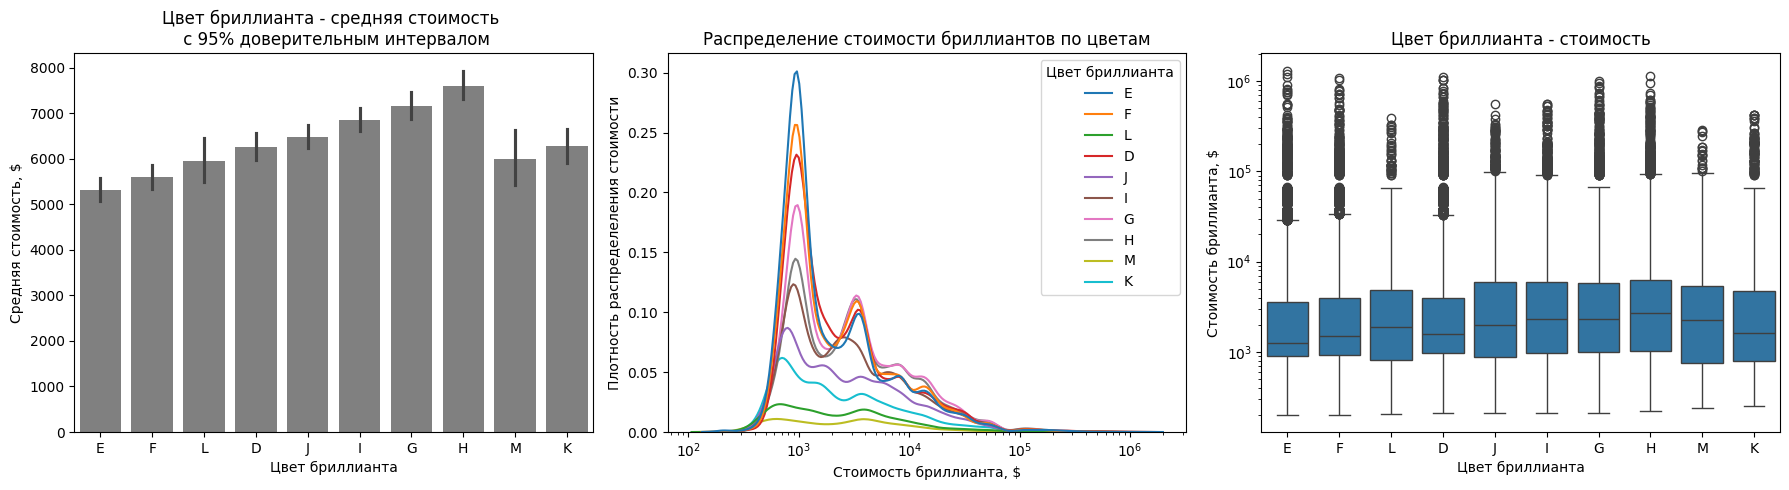

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.barplot(data=diamonds[['color', 'total_sales_price']].dropna(), x='color', y='total_sales_price', estimator='mean', errorbar=('ci', 95), ax=axes[0], color='gray')
sns.kdeplot(data=diamonds[['color', 'total_sales_price']].dropna(), hue='color', x='total_sales_price', log_scale=True, ax=axes[1])
sns.boxplot(data=diamonds[['color', 'total_sales_price']].dropna(), x='color', y='total_sales_price', log_scale=True)
axes[0].set(xlabel='Цвет бриллианта', ylabel='Средняя стоимость, $', title='Цвет бриллианта - средняя стоимость \n с 95% доверительным интервалом')
axes[1].set(xlabel='Стоимость бриллианта, $', ylabel='Плотность распределеления стоимости', title='Распределение стоимости бриллиантов по цветам')
axes[1].get_legend().set_title('Цвет бриллианта')
axes[2].set(xlabel='Цвет бриллианта', ylabel='Стоимость бриллианта, $', title='Цвет бриллианта - стоимость');
plt.tight_layout()

Постройте график `лабараторная оценка - кол-во бриллиантов`:

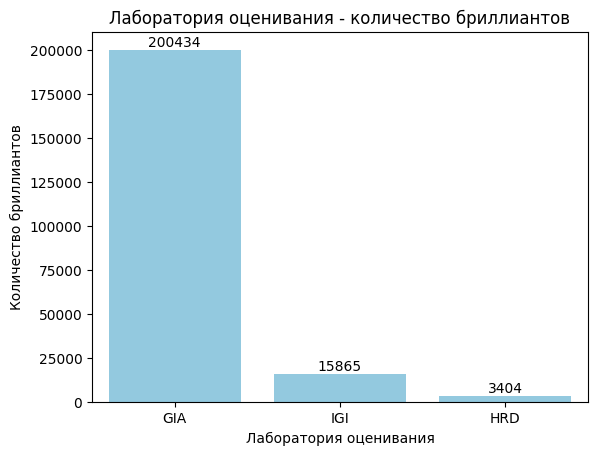

In [40]:
ax = sns.countplot(data=diamonds[['lab']].dropna(), x='lab', color='skyblue', order=diamonds.lab.value_counts().index)
ax.set(xlabel='Лаборатория оценивания', ylabel='Количество бриллиантов', title='Лаборатория оценивания - количество бриллиантов')
ax.bar_label(ax.containers[0]);

Постройте график `вес бриллианта - стоимость`:

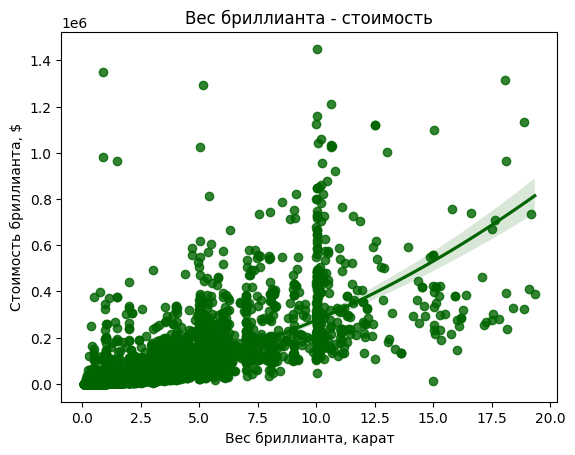

In [41]:
sns.regplot(data=diamonds[['carat_weight', 'total_sales_price']].dropna(), x='carat_weight', y='total_sales_price', order=2, color='darkgreen').set_title('Вес бриллианта - стоимость')
plt.xlabel('Вес бриллианта, карат')
plt.ylabel('Стоимость бриллианта, $');

Постройте график `система оценки GIA Cut - кол-во бриллиантов`:

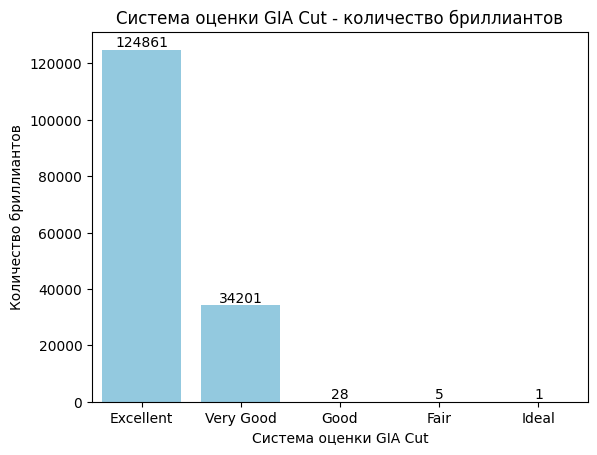

In [42]:
ax = sns.countplot(data=diamonds[['cut_quality']].dropna(), x='cut_quality', color='skyblue', order=diamonds.cut_quality.value_counts().index)
ax.set(xlabel='Система оценки GIA Cut', ylabel='Количество бриллиантов', title='Система оценки GIA Cut - количество бриллиантов')
ax.bar_label(ax.containers[0]);

Сделайте выводы по построенным графикам

In [43]:
diamonds.color.value_counts()

,count
color,
E,33103
F,31566
D,30873
G,29184
H,26073
I,22364
J,16898
K,11750
L,5683


1. Стоимость бриллианта, верноятно, коррелирует с его цветом. Однако, достоверно утверждать об этом  по постороенным графикам нельзя, так как необходмо учитывать комбинации 4 и более признаков, таких как (вес, цвет, чистота, огранка и т.д) Возможно, бриллианты E дешевле, чем H, но это не точно.
Бриллианты L и M представлены в датасете в меньшей степени, в достоверности распределения на графиках их характеристик уверенности еще меньше. Необходимо дополнительное исследование данных, лучше с помощью линейной регрессии.
2. Основной лабораторией по оценке и сертификации бриллиантов является GIA
3. Вес бриллианта в нектороорой степени коррелирует с его ценой, но проблемы те же, что и в п.1
4. Чаще всего встречается качество огранки Excelent и Very good. Более низкое качество встречается значительно реже, а более высокое почти не встречается вообще.